In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import LeaveOneOut, KFold , train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

### Performing Analysis for FEV1 Data

In [2]:
# Loading npy data.
X = np.load("/VS dir/PlayingSpiroData/Spiro-Data/npy_file/FEV1_FEATURES_60.npy")
y = np.load("/VS dir/PlayingSpiroData/Spiro-Data/npy_file/FEV1_LABELS_60.npy")

# Removing erroreneous data

X= pd.DataFrame(X).drop(index=[23,55,4,9,52,44,45,33,43,20,1,50])
y= pd.DataFrame(y).drop(index=[23,55,4,9,52,44,45,33,43,20,1,50])

### Initializing various Models

In [3]:
# Instantiating Random forrest Regressor.
RF = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=300,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Instantiating Decision Tree Regressor.
DT = DecisionTreeRegressor( criterion='squared_error',min_samples_leaf=1, 
                                min_samples_split=5 ,random_state=42)

# Instantiating Linear Regressor.
LR = LinearRegression()

# Estimator/Regressor Dictionary.
RegDict = { "Random_Forrest_Regression" :   RF,
            "Decision_Tree_Regression" :    DT,
            "Linear_Regression":            LR }

### Trying Leave one out Cross Validation on Random Forest , Decision Tree and Linear regression.

In [4]:
tot = len(X)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

# We run for every Regressor.
for Reg in RegDict:

    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
    print("For : ",Reg)
    Model = RegDict[Reg]
    prog = 0
    y_GT = []
    y_PT = []
    abserror=[]

    # For every split obtained by Leave_One_Out split function.
    for i,(train_index, test_index) in enumerate(loo.split(X)):

        #m To show some sort of progress.
        prog = prog + 1
        print("Progress : {0}/{1}".format(prog,tot),end = '\r')

        # Test-train split for the fold.
        X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
        y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]
        
        Model.fit(X_Train, np.ravel(y_Train))
        pred = Model.predict(X_Test)  

        y_GT.append(y_Test.iloc[0,0])
        y_PT.append(pred[0]) 
 
        abserror.append(np.abs( (y_Test.iloc[0,0] - pred[0])/ y_Test.iloc[0,0] ))

    # Calculating Metrics
    MAPE = 100 * np.mean(abserror)
    # print("Calculated MAPE : ", MAPE )
    # print("Calculated MAPE_func : ", MAPE_func(y_GT,y_PT))
    print()
    print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
    print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
    print("\tRoot Mean Square Error : " , mean_squared_error(y_GT,y_PT,squared=False))


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
For :  Random_Forrest_Regression
Progress : 48/48
	Mean Absolute Percentage Error :  6.224289571382801
	Mean Aabsolute Error :  0.18603059223184218
	Root Mean Square Error :  0.24610797310892654
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
For :  Decision_Tree_Regression
Progress : 48/48
	Mean Absolute Percentage Error :  7.893668767286284
	Mean Aabsolute Error :  0.23354166666666662
	Root Mean Square Error :  0.2958600829064431
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
For :  Linear_Regression
Progress : 48/48
	Mean Absolute Percentage Error :  92.62999490608946
	Mean Aabsolute Error :  2.700326991817928
	Root Mean Square Error :  4.839863018526574


### Apparently Linear Regression is not doing very well ... lets try Kfold cross validation as well for Linear Regression.

In [5]:
# Running Linear regression without Leave one out cross validation.

#70:30 Train-Test Split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

prog = 0
rmseerror = 0
aberror = 0
meaerror = 0
k=5

LinearReg = LinearRegression()
kfold = KFold(n_splits= k , shuffle= True,random_state=42)

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Linear regression for FEV1")

for i, (train_index, test_index) in enumerate(kfold.split(X)):

    X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
    y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]

    LinearReg.fit(X_Train,y_Train)
    y_hat = LinearReg.predict(X_Test)

    # print("Fold : ",i)
    # print("\tR2 score : ", LinearReg.score(X_Train,y_Train))
    # print("\tRMSE obtained :",mean_squared_error(y_Test,y_hat))
    # print("\tMAPE obtained :",100 * mean_absolute_percentage_error(y_Test,y_hat))
    # print("\tMEA obtained :",mean_absolute_error(y_Test,y_hat))
    # print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

    rmseerror = rmseerror + mean_squared_error(y_Test,y_hat,squared=False)
    aberror = aberror + 100 * mean_absolute_percentage_error(y_Test,y_hat) 
    meaerror = meaerror + mean_absolute_error(y_Test,y_hat)
    

print("\nMetrics obtained")
print("\tMean Absolute Percentage Error :",aberror/k)
print("\tMean Absolute Error :", meaerror/k)
print("\tRoot Mean Square Error :",rmseerror/k)
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("\nSeems like Linear regression is not working for us ! ")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Linear regression for FEV1

Metrics obtained
	Mean Absolute Percentage Error : 101.59862754760356
	Mean Absolute Error : 2.936759370443329
	Root Mean Square Error : 5.331385041056183
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=

Seems like Linear regression is not working for us ! 


### Identifying Feature importance from our Models.

In [12]:
# Gathering imortant features from the Random forest.
Impfeature = pd.DataFrame(DT.feature_importances_)

# Finding feature index whose Feature-Importance score is greater than Zero
FeatureIndex = list(Impfeature[Impfeature[0]>0].index)
FeatureIndex.sort()
print("Features that have Feature-Importance score greater than Zero : ",FeatureIndex)

Features that have Feature-Importance score greater than Zero :  [1, 9, 15, 21, 27, 34, 41, 57, 66, 77, 84, 88, 104, 120, 164]


In [23]:
DT_imp = pd.DataFrame(DT.feature_importances_)
RF_imp = pd.DataFrame(RF.feature_importances_)

DT_feature = list(DT_imp[DT_imp[0]>0].sort_values(by=0,ascending=False).index)
print(DT_imp[DT_imp[0]>0].sort_values(by=0,ascending=False))
print(DT_feature)

RF_feature = list(RF_imp[RF_imp[0]>0].sort_values(by=0,ascending=False).index)
print(RF_imp[RF_imp[0]>0].sort_values(by=0,ascending=False))
print(RF_feature)


            0
1    0.377829
164  0.131428
120  0.126700
34   0.114197
15   0.110982
84   0.046298
57   0.039058
104  0.013376
77   0.012740
66   0.010224
9    0.005967
41   0.004756
88   0.004641
21   0.001577
27   0.000226
[1, 164, 120, 34, 15, 84, 57, 104, 77, 66, 9, 41, 88, 21, 27]
            0
1    0.220957
9    0.053311
8    0.046442
4    0.037748
3    0.025344
..        ...
159  0.000254
144  0.000214
160  0.000163
22   0.000116
29   0.000060

[166 rows x 1 columns]
[1, 9, 8, 4, 3, 7, 52, 2, 165, 120, 15, 121, 66, 20, 5, 0, 6, 25, 21, 67, 19, 123, 119, 129, 139, 137, 73, 83, 18, 77, 80, 84, 11, 127, 10, 101, 56, 86, 78, 75, 122, 91, 135, 12, 81, 32, 41, 140, 158, 97, 124, 70, 88, 36, 85, 100, 93, 151, 30, 76, 14, 57, 96, 45, 164, 102, 26, 118, 58, 34, 44, 53, 141, 94, 59, 42, 114, 146, 90, 126, 132, 103, 142, 33, 95, 31, 147, 154, 60, 61, 69, 51, 125, 131, 156, 149, 23, 68, 27, 136, 99, 71, 105, 40, 24, 74, 54, 111, 128, 87, 92, 72, 13, 145, 38, 63, 55, 148, 98, 162, 115, 153, 1

### Lets try building Linear Regression Model using these features and lets see what happens .

In [11]:
# Running Linear regression without Leave one out cross validation.

#70:30 Train-Test Split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

X_new = X.iloc[:,FeatureIndex]
y_new = y

rmseerror = 0
aberror = 0
meaerror = 0

k = len(X_new)
LinearReg = LinearRegression()
kfold = KFold(n_splits= k , shuffle= True , random_state=42)

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Linear regression for FEV1")

for i, (train_index, test_index) in enumerate(kfold.split(X_new)):

    X_Train, X_Test = X_new.iloc[train_index],X_new.iloc[test_index]
    y_Train, y_Test = y_new.iloc[train_index],y_new.iloc[test_index]

    LinearReg.fit(X_Train,y_Train)
    y_hat = LinearReg.predict(X_Test)

    # print("Fold : ",i)
    # print("\tR2 score : ", LinearReg.score(X_Train,y_Train))
    # print("\tRMSE obtained :",mean_squared_error(y_Test,y_hat))
    # print("\tMAPE obtained :",100 * mean_absolute_percentage_error(y_Test,y_hat))
    # print("\tMEA obtained :",mean_absolute_error(y_Test,y_hat))

    rmseerror = rmseerror + mean_squared_error(y_Test,y_hat,squared=False)
    aberror = aberror + 100 * mean_absolute_percentage_error(y_Test,y_hat) 
    meaerror = meaerror + mean_absolute_error(y_Test,y_hat)

print("\nLinear Regression metrics with reduced feature set")
print("\tMean Absolute Percentage Error :",aberror/k)
print("\tMean Absolute Error :", meaerror/k)
print("\tRoot Mean Square Error :",rmseerror/k)
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Linear regression for FEV1

Linear Regression metrics with reduced feature set
	Mean Absolute Percentage Error : 7.477817429728404
	Mean Absolute Error : 0.22140710613087847
	Root Mean Square Error : 0.22140710613087847
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=


### Lets try building Random forest using these features and lets see what happens .

In [12]:


X_new = X.iloc[:,FeatureIndex]
y_new = y

RF_new = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=100,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Total number of the splits
tot = len(X_new)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

prog = 0
y_GT = []
y_PT = []
abserror=[]

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Random Forest Regressor for FEV1")

# For every split obtained by Leave_One_Out split function.
for i,(train_index, test_index) in enumerate(loo.split(X)):
    
    # To show some sort of progress.
    prog = prog + 1
    print("Progress : {0}/{1}".format(prog,tot),end = '\r')

    # Test-train split for the fold.
    X_Train, X_Test = X_new.iloc[train_index],X_new.iloc[test_index]
    y_Train, y_Test = y_new.iloc[train_index],y_new.iloc[test_index]
    
    # Training new Random Forest ensemble.
    RF_new.fit(X_Train, np.ravel(y_Train))
    pred = RF_new.predict(X_Test)  

    # Storing the values of Ground truth and Predicted value for future use.
    y_GT.append(y_Test.iloc[0,0])
    y_PT.append(pred[0]) 

    # Absolute percentage error
    abserror.append(np.abs( (y_Test.iloc[0,0] - pred[0])/ y_Test.iloc[0,0] ))

# Calculating Metrics
MAPE = 100 * np.mean(abserror)
# print("Calculated MAPE : ", MAPE )
# print("Calculated MAPE_func : ", MAPE_func(y_GT,y_PT))

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
print("Random forest metrics with reduced feature set")
print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT))
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Random Forest Regressor for FEV1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Random forest metrics with reduced feature set
	Mean Absolute Percentage Error :  5.752424753685239
	Mean Aabsolute Error :  0.17195902161380264
	Mean Square Error :  0.05039319005210293
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


### Plotting the MAPE values againsts the individuals

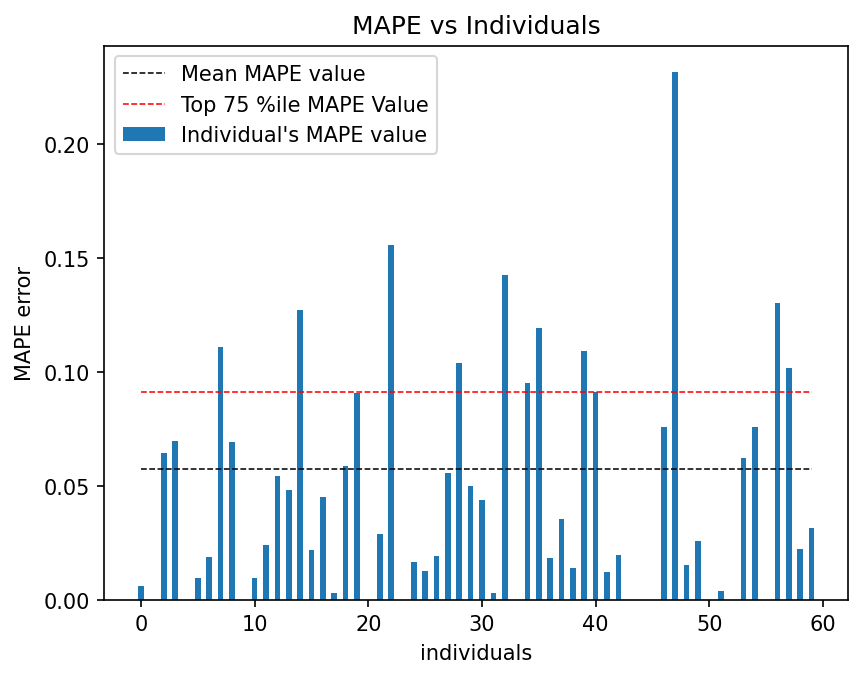

In [13]:
# Acquiring the index of individuals.
individuals = list(X.index)

# Acquiring the threhold for top quartile.
prc = copy.deepcopy(abserror)
prc.sort()
prc75 = prc[(len(prc)*3)//4]

# Plotting the Data.
plt.figure(dpi= 150)
plt.bar(individuals,abserror,width=0.5)
plt.plot(individuals,[MAPE/100]*48,color = 'black',linestyle='dashed',linewidth=0.75)
plt.plot(individuals,[prc75]*48,color = 'red',linestyle='dashed',linewidth=0.75)
plt.xlabel("individuals")
plt.ylabel("MAPE error")
plt.title("MAPE vs Individuals")
plt.legend(["Mean MAPE value","Top 75 %ile MAPE Value","Individual's MAPE value"])
plt.show()


### Making sense with the Demogragraphic Data

In [19]:
# Reading Demographic Data .
DemoData = pd.read_csv("/VS dir/PlayingSpiroData/Spiro-Data/csv_files/Demographic_Dataset.csv").set_index('index')

# Removing the erroreneous data.
DemoData =  DemoData.drop(index=[23,55,4,9,52,44,45,33,43,20,1,50])

# Getting a mean of the data.
a = DemoData.mean()
print(a)
Meandata = dict(a)


gPEF        6.948125
gFEV1       2.972917
gFVC        3.217708
Age        25.104167
Height    168.745833
Weight     64.708333
dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_15308\4225503757.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  a = DemoData.mean()


In [20]:
# finding datapoints in the top quartile of the error
HighFEV1 = DemoData[abserror>prc75]

# Getting a mean of the data.
b = HighFEV1.mean()
print(b)
Mean_HighFEV1 = dict(b)


gPEF        7.032727
gFEV1       3.133636
gFVC        3.455455
Age        23.454545
Height    173.749091
Weight     65.636364
dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_15308\828111311.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  b = HighFEV1.mean()


In [21]:
# Putting together the  mean data 
observations = pd.DataFrame.from_dict(data=Meandata,orient='index')
observations[1] = pd.DataFrame.from_dict(data=Mean_HighFEV1,orient='index')

# absolute difference both the mean values
observations['diff'] = abs(observations[1] - observations[0])
print(observations)

                 0           1      diff
gPEF      6.948125    7.032727  0.084602
gFEV1     2.972917    3.133636  0.160720
gFVC      3.217708    3.455455  0.237746
Age      25.104167   23.454545  1.649621
Height  168.745833  173.749091  5.003258
Weight   64.708333   65.636364  0.928030


### It appears height is the most striking demographic feature in top quartile of MAPE error for FEV1